<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's install and upgrade the necessary packages

In [15]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade



Let's import all the necessary functions and packages

In [16]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

Check the versions of the packages

In [17]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [18]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load data

Load the training and test set and display its shape

In [19]:

#https://drive.google.com/file/d/18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw/view?usp=sharing
#https://drive.google.com/file/d/12aEK83cwTZyxtz2blCGxTpseZO5_dw6Z/view?usp=sharing
# Google Drive file ID of your zip file
file_id = '12aEK83cwTZyxtz2blCGxTpseZO5_dw6Z'
# URL for downloading the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
# Destination path for the downloaded zip file (in Google Colab)
zip_file_path = '/content/file.zip'
# Download the file
gdown.download(url, zip_file_path, quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=12aEK83cwTZyxtz2blCGxTpseZO5_dw6Z

but Gdown can't. Please check connections and permissions.

If the cell above is not working then execute the next one

In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


ValueError: The domain policy has disabled Drive File Stream: https://support.google.com/a/answer/7496409

In [ ]:
!cp '/content/drive/MyDrive/images.zip' zipfile

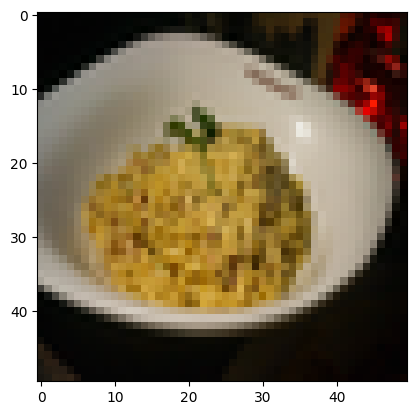

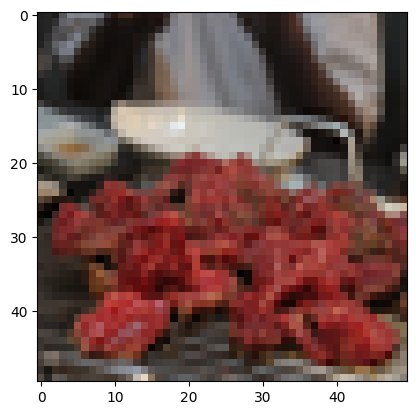

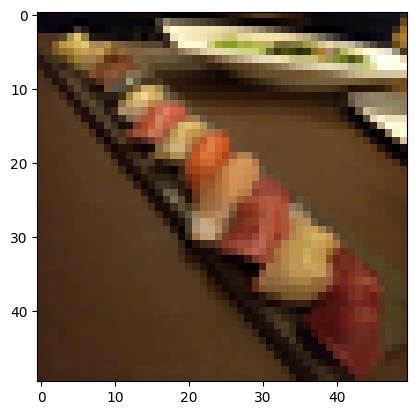

In [21]:
zip_file_path = 'images.zip'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')

# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/extracted_folder/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in file_list:
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resizing all the images
resized_images = []
# Define the target size
width = 50
height = 50
target_size = (width, height)

# Resize each image to the target size using LANCZOS resampling
for img in X:
    resized_img = img.resize(target_size, Image.LANCZOS)
    resized_images.append(resized_img)
# Convert the list of resized images to a NumPy array
X_array = np.array([np.array(img) for img in resized_images])
plt.imshow(X_array[1000])
plt.show()
plt.imshow(X_array[500])
plt.show()
plt.imshow(X_array[0])
plt.show()

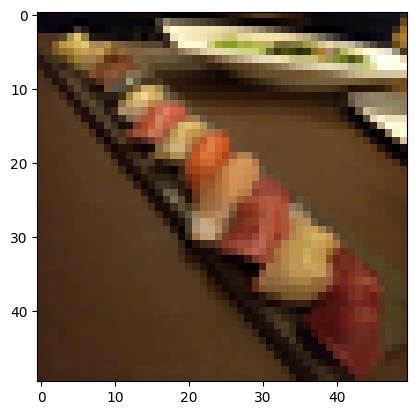

In [22]:
# Display the first resized image
plt.imshow(X_array[0])
plt.show()


In [23]:
SEED=33
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=SEED)

Preprocess the feature vectors (normalize data)

In [24]:
# Input data preprocessing
print(np.min(X_train), np.max(y_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#normalization
X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 4
1154 train samples
289 test samples


Preprocess the labels (one-hot encodings)

In [25]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 4
First label is now =  [0. 0. 1. 0. 0.]


## Validation data
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [26]:
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED) # for reproducibility

##Build a Baseline model

In [27]:
def CNNModel(num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [28]:
num_classes = 5
model = CNNModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         495,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501,477 (1.91 MB)

 Trainable params: 501,477 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

##Our Model

In [29]:
class MyCNNModel(kt.HyperModel):
    def __init__(self, loss="categorical_crossentropy"):
        self.loss = loss

    def build(self, hp):
        model = self.build_CNN(hp)
        return model

    def build_CNN(self, hp):
        hp_units1 = hp.Int('unitsL1', min_value=16, max_value=256, step=16)
        hp_units2 = hp.Int('unitsL2', min_value=16, max_value=256, step=16)
        hp_activation = hp.Choice("activation", ["gelu", "relu"])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        hp_optimizer = hp.Choice('optimizer', values=['adam'])

        model = self.build_CNN_hp(
            hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
            hp_learning_rate=hp_learning_rate, hp_optimizer=hp_optimizer, hp_dropout_rate=hp_dropout_rate
        )
        return model

    def build_CNN_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate,
                     hp_optimizer, hp_dropout_rate):
        model = Sequential()
        model.add(Conv2D(hp_units1, (3, 3), activation=hp_activation, input_shape=(50, 50, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(hp_units2, (3, 3), activation=hp_activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(hp_units1, activation=hp_activation))
        model.add(Dropout(hp_dropout_rate))
        model.add(Dense(hp_units2, activation=hp_activation))
        model.add(Dropout(hp_dropout_rate))
        model.add(Dense(5, activation="softmax"))

        optimizer = Adam(learning_rate=hp_learning_rate)
        loss = "categorical_crossentropy"

        model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
        return model

    def fit(self, hp, model, *args, **kwargs):
        datagen_train = ImageDataGenerator(
           rotation_range=10,
           width_shift_range=0.1,
            height_shift_range=0.1,
           shear_range=0.2,
           zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )


        datagen_train.fit(X_train)

        datagen_val = ImageDataGenerator(
          rotation_range=10,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          vertical_flip=True,
          fill_mode='nearest'
        )


        datagen_val.fit(X_val)

        return model.fit(
            datagen_train.flow(X_train, y_train, batch_size=128, shuffle=True),
            validation_data=datagen_val.flow(X_val, y_val, batch_size=128, shuffle=True)
        )


In [30]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyCNNModel(),
                     objective='val_accuracy',
                     max_epochs=20,

                     max_consecutive_failed_trials=5,
                     project_name='my_cnn_tuning',
                     directory='my_cnn_tuning',
)

# Summarize the search space
tuner.search_space_summary()


Search space summary
Default search space size: 6
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'gelu', 'conditions': [], 'values': ['gelu', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam'], 'ordered': False}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

In [31]:
batch_size = 128
epochs = 5


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.2106 - loss: 1.6558 - val_accuracy: 0.2684 - val_loss: 1.5375
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.3552 - loss: 1.4764 - val_accuracy: 0.4805 - val_loss: 1.3578
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.5584 - loss: 1.2691 - val_accuracy: 0.5108 - val_loss: 1.2050
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.5922 - loss: 1.0806 - val_accuracy: 0.5022 - val_loss: 1.1722
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.6470 - loss: 0.9824 - val_accuracy: 0.5238 - val_loss: 1.0979


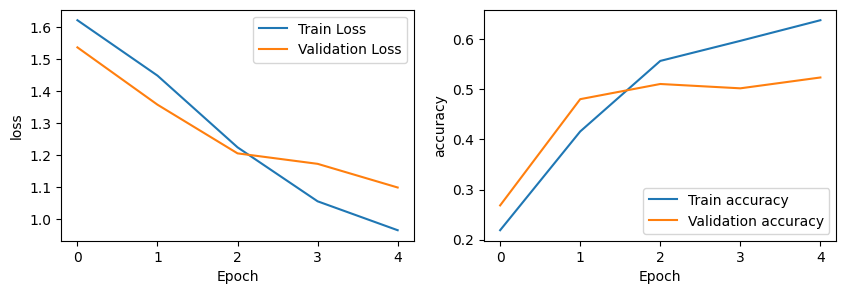

In [32]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
plot_history(history)

Save the baseline model in the workspace

In [33]:
model.save('/content/baseline_model.keras')

In [34]:
print("Original shape of X_train:", X_train.shape)


Original shape of X_train: (923, 50, 50, 3)


## Training the best model


Trial 28 Complete [00h 00m 44s]
val_accuracy: 0.28138527274131775

Best val_accuracy So Far: 0.4285714328289032
Total elapsed time: 00h 09m 45s
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2537 - loss: 1.5791 - val_accuracy: 0.5238 - val_loss: 1.2422
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5264 - loss: 1.2167 - val_accuracy: 0.5022 - val_loss: 1.1485
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6423 - loss: 0.9567 - val_accuracy: 0.6234 - val_loss: 0.8630
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7405 - loss: 0.7264 - val_accuracy: 0.6364 - val_loss: 0.9112
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7770 - loss: 0.6467 - val_accuracy: 0.6537 - val_loss: 0.8999
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7632 - loss: 0.5702 - val_accuracy: 0.6623 - val_loss: 1.0535
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8135 - loss: 0.5533 - val_accuracy: 

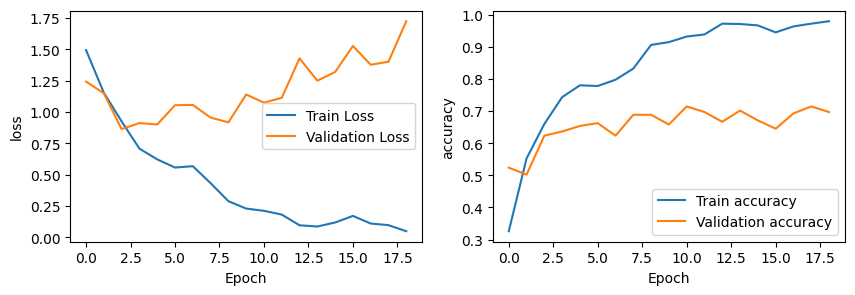

Best epoch: 11


In [35]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=10,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=5,
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for maximum 50 epochs
best_model = tuner.hypermodel.build(best_hps)

#train the model with the whole data set
#we should eliminate the validation state since it is not useful anymore
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

# Plot the training summary
plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the best model in the workspace

In [36]:
best_model.save('/content/best_model.keras')

#Evaluation


## Baseline evaluation

Print the loss and accuracy of the trained baseline model.

In [37]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 1.2291696071624756
Test accuracy: 0.5328719615936279


## Best model evaluation
Print the best hyperparameters found by the hyperband tuner.

Print the loss and accuracy of the best model.

Print the accuracy increment in the test set.

The test set is not subject to augmentation as it should not be manipulated, but only be used as references for evaluation.

In [38]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

# Evaluate and print results
best_score = best_model.evaluate(X_test, y_test, verbose=0)
print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Best model
Best parameters: {'unitsL1': 240, 'unitsL2': 64, 'activation': 'gelu', 'learning_rate': 0.001, 'dropout_rate': 0.4, 'optimizer': 'adam', 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.8250758051872253
Test accuracy: 0.7162629961967468
Test accuracy improvement: 34.41559095259252 %


##Pretrained network

In [41]:
# Define input shape for the model (224x224 is common for ResNet)
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
#modify the dimensions of the images to adapt to the input of the neural network

#pretrained network ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add GlobalAveragePooling2D to reduce spatial dimensions to a vector
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a Dense layer with number of units matching your number of classes
x = Dense(units=num_classes, activation='softmax')(x)  # Replace NUM_CLASSES with your actual number

# Create the final model
model = Model(inputs=base_model.input, outputs=x)


train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(X_train, y_train, batch_size=128, shuffle=True)

validation_generator = val_datagen.flow(X_val, y_val, batch_size=128, shuffle=True)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust epochs and steps_per_epoch based on your dataset size
model.fit(train_generator, epochs=20, validation_data=validation_generator)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 169s 16s/step - accuracy: 0.5110 - loss: 1.5501 - val_accuracy: 0.1991 - val_loss: 29.5711
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 17s/step - accuracy: 0.7973 - loss: 1.1108 - val_accuracy: 0.1948 - val_loss: 6366.1797
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 125s 15s/step - accuracy: 0.8638 - loss: 0.7959 - val_accuracy: 0.1948 - val_loss: 2430.3767
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 15s/step - accuracy: 0.8559 - loss: 0.5052 - val_accuracy: 0.1818 - val_loss: 851.9237
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.8176 - loss: 0.7527 - val_accuracy: 0.1991 - val_loss: 1452.2911
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 134s 14s/step - accuracy: 0.8660 - loss: 0.3466 - val_accuracy: 0.1991 - val_loss: 950.9366
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 14s/step - accuracy: 0.9037 - loss: 0.3072 - val_accuracy: 0.1991 - val_loss: 623.8152
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - accuracy: 0.9179 - loss: 0.2198 - val_accuracy: 0.

##Pretrained Model evaluation

In [42]:
best_score = model.evaluate(X_test, y_test, verbose=0)

# Evaluate and print results
best_score = best_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Test loss: 0.8250758051872253
Test accuracy: 0.7162629961967468
Test accuracy improvement: 34.41559095259252 %
